# Urban Sound Classification with Neural Networks

In this study, two models of neural networks are developed for the classification of sound events based on audio files from the UrbanSound8K dataset. The first model takes advantage of the robust machine learning techniques developed for image classification. It is a CNN that taking in input the Mel spectrogram image tries to label audio excerpt. The second model that was developed and analysed is a classical Feedforward neural network using as input MSCCs statistics extracted from the previously cited audio dataset.
Using these self-developed architectures was achieved an aver- age f1-score of 74% (78% for the CNN, 70% for the Feedforward) in classifying the top 5 classes. The predictions of the two models were applied to 10 classes.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
project_path = "/content/gdrive/MyDrive/ColabData/UrbanSound8K"

Mounted at /content/gdrive


In [2]:
import os

audio_path = os.path.join(project_path,"audio")
metadata_path = os.path.join(project_path,"metadata/UrbanSound8K.csv")

Get metadata about audio files

In [3]:
import pandas as pd
import numpy as np

def get_metadata(path):
  df = pd.io.parsers.read_csv(path)
  return df

md = get_metadata(metadata_path)
print(md.shape)
md.head(10)


(8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


display label distribution among folders

In [4]:
appended = []
for i in range(1,11):
    appended.append(md[md.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,dog_bark,air_conditioner,children_playing,drilling,street_music,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


In [5]:
'''
def get_row(filename, md=md):
  return md.loc[md['slice_file_name'] == filename]

def get_fsID(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][1]  
  else: 
     return []

def get_start_time(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][2]  
  else: 
     return []

def get_end_time(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][3]  
  else: 
     return []

def get_salience(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][4]  
  else: 
     return []

def get_fold(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][5]  
  else: 
     return []

def get_classID(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][6]  
  else: 
     return []  

def get_class(filename, md=md):  #NON FUNZIONA!
  
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][7]  
  else: 
     return []                          
'''
def get_row(filename, md=md):
  return md.loc[md['slice_file_name'] == filename]

def get_classID(filename, md=md):
  r = get_row(filename, md).values.tolist()
  if len(r):
    return r[0][6]  
  else: 
     return []  

(79554,)


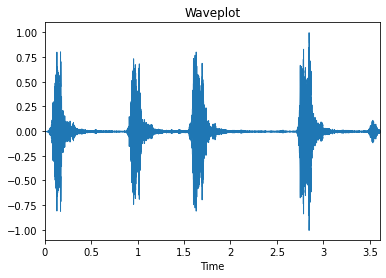

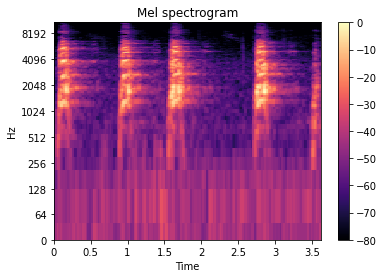

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

audio_path_sample = os.path.join(project_path,"audio","foldEs","7383-3-1-0.wav")

def show_waveplot(y, sr):
  plt.figure()
  img = librosa.display.waveplot(y=y, sr=sr)
  plt.title('Waveplot')
  plt.show()

def show_mel_spectrogram(y, sr):
  ax = plt.subplot()
  M = librosa.feature.melspectrogram(y=y, sr=sr)
  M_db = librosa.power_to_db(M, ref=np.max)
  im = librosa.display.specshow(M_db, y_axis='log', x_axis='time')
  plt.title('Mel spectrogram')
  plt.colorbar(im)
  plt.show()

y, sr = librosa.load(audio_path_sample)
y = librosa.util.normalize(y)
y = librosa.util.fix_length(y, size=round(22050 * 3.6079037445029747))
print(y.shape)

show_waveplot(y=y, sr=sr)
show_mel_spectrogram(y=y, sr=sr)

In [7]:
training_folds = ["fold1", "fold2", "fold3", "fold4", "fold6"]
test_folds = ["fold5", "fold7", "fold8", "fold9", "fold10"]

In [8]:
dim_list = [float(row['end'])-float(row['start']) for index, row in md.iterrows()]
avg_sec = sum(dim_list) / len(dim_list)
print("average excerpt lenght: {0}".format(avg_sec))

average excerpt lenght: 3.6079037445029747


Extracting the Mel spectrogram from the audio files and storing them in csv files.

In [9]:
from os import listdir
import csv

csv_folder_path = os.path.join(project_path, "features-csv")
global_sr = 22050
max_len = round(global_sr * avg_sec)

def create_header(sr):
  header = ["filename"]
  for i in range(0, round(sr * avg_sec)):
    header.append('y.{}'.format(i))
  header.append("sr")
  header.append("label")
  return header

def create_csv(folder_data):
  csv_file_name = os.path.join(csv_folder_path, 'features_' + folder_data + '.csv')
  #md = get_metadata(metadata_path)
  with open(csv_file_name, mode='w') as file:
    file_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  tmp_l = []
  with open(csv_file_name, mode='a') as file:
        create_header(global_sr)
        writer = csv.writer(file)
        writer.writerow(tmp_l)

  folderpath = os.path.join(audio_path, folder_data)  
  for f in listdir(folderpath):
    if f.endswith(".wav"):
      y, sr = librosa.load(os.path.join(folderpath, f), sr=global_sr) #load and resample data
      y = librosa.util.fix_length(y, size=max_len)
      y = librosa.util.normalize(y) #normalizes
      M = librosa.feature.melspectrogram(y=y, sr=sr)
      M_db = librosa.core.power_to_db(M) #log scaled 
      #y = librosa.util.normalize(y)
      M_val = M_db.reshape(128*156) 

      tmp_l = []
      tmp_l.append(f)
      tmp_l.extend(M_val)
      tmp_l.append(sr)
      tmp_l.append(get_classID(f, md))

      with open(csv_file_name, mode='a') as file:
        writer = csv.writer(file)
        writer.writerow(tmp_l)

  return csv_file_name


In [ ]:
for fold in training_folds: 
  name = create_csv(fold)
  print(name)

/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold1.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold2.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold3.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold4.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold6.csv


In [10]:
for fold in test_folds: 
  name = create_csv(fold)
  print(name)

/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold5.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold7.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold8.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold9.csv
/content/gdrive/MyDrive/ColabData/UrbanSound8K/features-csv/features_fold10.csv


Defining function to create the actual dataset

In [11]:
from numpy import genfromtxt

def get_data_and_labels(folds_list): 
  ''''
  returns a couple(x, y)
    x is a numpy.array containig data of mel spectrogram of a group of audio files
    y is a numpy.array containig labels of audio files
  fold_list: list of folders containing audio files of concern
  '''
  all_filenames = [os.path.join(csv_folder_path, 'features_'+ fold +'.csv') for fold in folds_list] #gets names of csv files related to audio files of concern
  csv_data = np.concatenate([genfromtxt(f, delimiter=',') for f in all_filenames])
  #csv_data = pd.concat([pd.read_csv(f, names=create_header(sr)) for f in all_filenames]) #get pd.array data and concatenate data stored in different csv files
  return csv_data[:,1:-2], csv_data[:,-1]


defining One-Hot Encoding for labels

In [12]:
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder

classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

classes_list = asarray([[s] for s in classes])
encoder = OneHotEncoder(sparse=False)
one_hot_enc = encoder.fit_transform(classes_list)

def get_class(l):
  return classes[np.argmax(l)]

def one_hot_encode(classname):
  labels = np.zeros(len(classes_list))
  index = np.where(classes_list == classname)[0][0]
  return one_hot_enc[index]

print(one_hot_enc[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Start building the CNN model

Building the training set for the CNN

In [13]:
from sklearn.preprocessing import StandardScaler

X_train, Y_train = get_data_and_labels(training_folds)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = X_train.reshape(-1, 128, 156, 1)

Y_train = np.array([one_hot_enc[int(v)] for v in Y_train])
Y_train = Y_train.reshape(-1, 10)

print(X_train.shape, Y_train.shape)

(4499, 128, 156, 1) (4499, 10)


Building the test set

In [14]:
X_test = []
Y_test = []

for f in test_folds:
  #print(f)
  x, y = get_data_and_labels([f])
  x = scaler.transform(x)
  x = x.reshape(-1, 128, 156, 1)
  X_test.append(x)

  y = np.array([one_hot_enc[int(v)] for v in y])
  y = y.reshape(-1, 10)
  Y_test.append(y)

'''
X_test, Y_test = get_data_and_labels(test_folds)
X_test = X_test.reshape(-1, 128, 156, 1)

Y_test = np.array([one_hot_enc[int(v)] for v in Y_test])
Y_test = Y_test.reshape(-1, 10) 
print(X_test.shape, Y_test.shape)'''

for i in range(0, len(X_test)):
  print("fold{0}".format(test_folds[i]))
  print(" X data: {0}".format(X_test[i].shape))
  print(" Y data: {0}".format(Y_test[i].shape))

foldfold5
 X data: (936, 128, 156, 1)
 Y data: (936, 10)
foldfold7
 X data: (838, 128, 156, 1)
 Y data: (838, 10)
foldfold8
 X data: (806, 128, 156, 1)
 Y data: (806, 10)
foldfold9
 X data: (816, 128, 156, 1)
 Y data: (816, 10)
foldfold10
 X data: (837, 128, 156, 1)
 Y data: (837, 10)


just a duble check on data

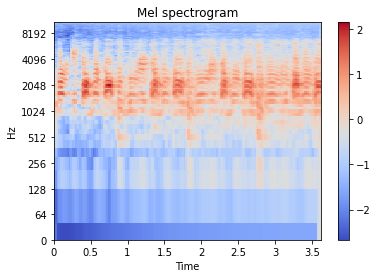

In [15]:
plt.plot()
im = librosa.display.specshow(X_test[0][127][:,:,0], y_axis='log', x_axis='time')
plt.title('Mel spectrogram')
plt.colorbar(im)
plt.show()

## Start building the CNN

In [16]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models, Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

num_classes = 10 
epochs = 20
batch_size = 32

In [17]:
def plt_figs(hist, title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  ax1.plot(hist.history['accuracy'], label='accuracy')
  ax1.plot(hist.history['val_accuracy'], label = 'val_accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc='lower right')

  ax2.plot(hist.history['loss'])
  ax2.plot(hist.history['val_loss'])
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(['train', 'validation'], loc='upper right')
  fig.suptitle(title, fontsize=16 )
  fig.show()

In [18]:
def create_CNN():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), input_shape=(128, 156, 1)))
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(filters=32, kernel_size=(5, 5)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D((3,3)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(filters=64, kernel_size=(3, 3)))
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(filters=64, kernel_size=(3,3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(filters=128, kernel_size=(2, 2)))
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(filters=128, kernel_size=(2, 2)))
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(filters=128, kernel_size=(2, 2)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Flatten())
  model.add(layers.Dense(units=128))
  model.add(layers.Activation('relu'))
  model.add(layers.Dense(units=num_classes, activation = 'softmax'))

  model.summary()
  
  model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
  return model

cnn_model = create_CNN()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 152, 32)      832       
_________________________________________________________________
activation (Activation)      (None, 124, 152, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 148, 32)      25632     
_________________________________________________________________
activation_1 (Activation)    (None, 120, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 47, 64)        1

training the model with Kfold evaluation

In [19]:
from sklearn.model_selection import KFold

i=1
kf = KFold(n_splits=10)
for train, test in kf.split(X_train):
  title = "training for fold "+ str(i)
  i +=1
  print(title)
  history = cnn_model.fit(X_train[train], Y_train[train], 
                    epochs = epochs,  
                    batch_size = batch_size,
                    callbacks= tf.keras.callbacks.EarlyStopping(patience=3),
                    validation_data= (X_train[test], Y_train[test])
                    )
  #plt_figs(history, title)

training for fold 1
Epoch 1/20
127/127 [==============================] - 42s 101ms/step - loss: 1.8418 - accuracy: 0.3443 - val_loss: 1.6670 - val_accuracy: 0.3844
Epoch 2/20
127/127 [==============================] - 12s 91ms/step - loss: 1.3274 - accuracy: 0.5265 - val_loss: 1.3031 - val_accuracy: 0.5467
Epoch 3/20
127/127 [==============================] - 12s 91ms/step - loss: 0.9991 - accuracy: 0.6565 - val_loss: 1.2145 - val_accuracy: 0.5822
Epoch 4/20
127/127 [==============================] - 11s 90ms/step - loss: 0.7908 - accuracy: 0.7347 - val_loss: 1.2775 - val_accuracy: 0.6044
Epoch 5/20
127/127 [==============================] - 12s 91ms/step - loss: 0.6305 - accuracy: 0.7832 - val_loss: 1.0717 - val_accuracy: 0.6178
Epoch 6/20
127/127 [==============================] - 12s 92ms/step - loss: 0.5095 - accuracy: 0.8279 - val_loss: 1.5646 - val_accuracy: 0.5733
Epoch 7/20
127/127 [==============================] - 12s 92ms/step - loss: 0.4135 - accuracy: 0.8607 - val_loss: 1

Plotting statistics and Confusion matrix

                  precision    recall  f1-score   support

 air_conditioner     0.5669    0.5000    0.5313       500
        car_horn     0.8272    0.7149    0.7670       221
children_playing     0.5455    0.7200    0.6207       500
        dog_bark     0.7357    0.7740    0.7544       500
        drilling     0.3649    0.4160    0.3888       500
   engine_idling     0.4618    0.2878    0.3546       483
        gun_shot     0.7521    0.9728    0.8483       184
      jackhammer     0.3692    0.3717    0.3705       452
           siren     0.8234    0.7354    0.7769       393
    street_music     0.6220    0.6220    0.6220       500

        accuracy                         0.5785      4233
       macro avg     0.6069    0.6115    0.6034      4233
    weighted avg     0.5793    0.5785    0.5736      4233



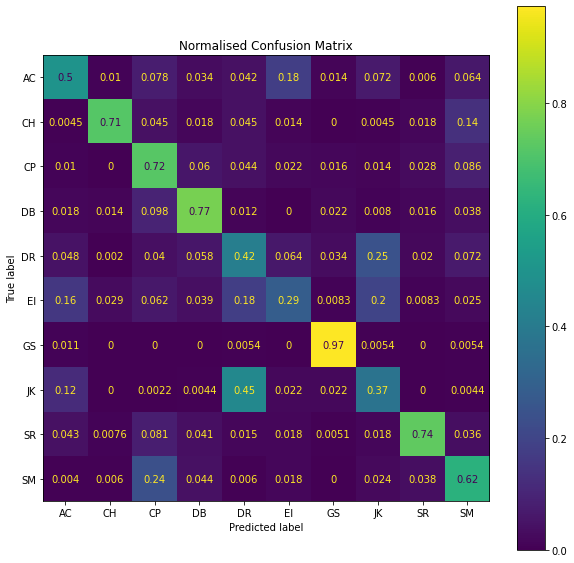

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, accuracy_score, explained_variance_score

classes_shorten = ['AC', 'CH', 'CP', 'DB', 'DR', 'EI', 'GS', 'JK', 'SR', 'SM']

unified_X_test = np.empty(shape=(0, 128, 156, 1))
unified_Y_test = np.empty(shape=(0, 10))
for i in range(0, 5):
    unified_X_test = np.append(unified_X_test, X_test[i], axis=0)
    unified_Y_test = np.append(unified_Y_test, Y_test[i], axis=0)

y_pred = cnn_model.predict(unified_X_test)
y_pred = np.argmax(y_pred, axis=1) 
y_target = np.argmax(unified_Y_test, axis=1)

cm = confusion_matrix(y_target, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_shorten)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalised Confusion Matrix")
disp.plot(ax=ax)

print(classification_report(y_target, y_pred, target_names=classes, digits=4))

In [21]:
cvscores = []
for i in range(0,len(X_test)):
  scores = cnn_model.evaluate(X_test[i], Y_test[i], verbose=0)
  cvscores.append(scores[1]*100)
  print("{0} {1}: {2:.2f}".format(test_folds[i], cnn_model.metrics_names[1], scores[1]*100))
print("mean accuracy: {0:.2f}%   standard deviation: {1:.2}%".format(np.mean(cvscores), np.std(cvscores)))

fold5 accuracy: 54.81
fold7 accuracy: 52.98
fold8 accuracy: 61.41
fold9 accuracy: 60.29
fold10 accuracy: 60.33
mean accuracy: 57.97%   standard deviation: 3.4%


# Developing Feed forward neural network 

Extracting MFCCs from mel pectrogram. Exstrached features for each frame are
- min
- max
- median
- average
- variance
- skewness
- kurtotis
total array lenght: 140

In [22]:
from scipy.stats import skew, kurtosis

def extract_mel_feats(mel_array):
  X_feats = np.empty(shape=(0, 140))

  for elem in mel_array:
    S = elem.reshape(128, 156)
    mfcc = librosa.feature.mfcc(S=S) 
  
    S_features = list()
    for el in mfcc: 
      S_features.append(np.amin(el))
      S_features.append(np.amax(el))
      S_features.append(np.median(el))
      S_features.append(np.mean(el))
      S_features.append(np.var(el))
      S_features.append(skew(el))
      S_features.append(kurtosis(el))
    S_features = np.asarray(S_features, dtype=float).reshape(1, 140)

    X_feats = np.append(X_feats, S_features, axis=0)

  return X_feats

building the training set

In [23]:
X_train_feats = extract_mel_feats(X_train)

scaler = StandardScaler()
X_train_feats = scaler.fit_transform(X_train_feats)

print(X_train_feats.shape)

(4499, 140)


building the testing set

In [24]:
X_test_feats = []

for i in range(0, len(X_test)):
  x = extract_mel_feats(X_test[i])
  x = scaler.transform(x)
  X_test_feats.append(x)
  
for i in range(0, len(X_test)):
  print("fold{0}".format(i))
  print(" X data: {0}".format(X_test[i].shape))
  print(" Y data: {0}".format(Y_test[i].shape))

fold0
 X data: (936, 128, 156, 1)
 Y data: (936, 10)
fold1
 X data: (838, 128, 156, 1)
 Y data: (838, 10)
fold2
 X data: (806, 128, 156, 1)
 Y data: (806, 10)
fold3
 X data: (816, 128, 156, 1)
 Y data: (816, 10)
fold4
 X data: (837, 128, 156, 1)
 Y data: (837, 10)


## building the Feed forward model

In [25]:
def create_seqNN():
  model = models.Sequential()
  model.add(layers.BatchNormalization(input_shape=(X_train_feats.shape[1],)))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.4))
  
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.4))
  
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.4))
  
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.4))
  
  model.add(layers.Dense(units=num_classes, activation = 'softmax'))

  model.summary()
  
  model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
  
  return model

feat_model = create_seqNN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 140)               560       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               36096     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

Training the model with K-fold evaluation

In [26]:
i=1
kf = KFold(n_splits=5)
for train, test in kf.split(X_train):
  title = "training for fold "+ str(i)
  i +=1
  print(title)
  history = feat_model.fit(X_train_feats[train], Y_train[train], 
                    epochs = epochs,  
                    batch_size = batch_size,
                    validation_data= (X_train_feats[test], Y_train[test]),
                    callbacks= tf.keras.callbacks.EarlyStopping(patience=3))
  #plt_figs(history, title)

training for fold 1
Epoch 1/20
113/113 [==============================] - 5s 17ms/step - loss: 2.5541 - accuracy: 0.3487 - val_loss: 1.8065 - val_accuracy: 0.3756
Epoch 2/20
113/113 [==============================] - 2s 14ms/step - loss: 1.5519 - accuracy: 0.5279 - val_loss: 1.8676 - val_accuracy: 0.4844
Epoch 3/20
113/113 [==============================] - 2s 14ms/step - loss: 1.2829 - accuracy: 0.5813 - val_loss: 2.0351 - val_accuracy: 0.5278
Epoch 4/20
113/113 [==============================] - 2s 14ms/step - loss: 1.0995 - accuracy: 0.6382 - val_loss: 1.9626 - val_accuracy: 0.5111
training for fold 2
Epoch 1/20
113/113 [==============================] - 2s 14ms/step - loss: 1.1650 - accuracy: 0.6152 - val_loss: 0.8210 - val_accuracy: 0.7022
Epoch 2/20
113/113 [==============================] - 2s 14ms/step - loss: 0.9845 - accuracy: 0.6755 - val_loss: 0.9589 - val_accuracy: 0.6567
Epoch 3/20
113/113 [==============================] - 2s 14ms/step - loss: 0.8694 - accuracy: 0.7055 -

Statistics and confusion matrix

                  precision    recall  f1-score   support

 air_conditioner     0.5056    0.5460    0.5250       500
        car_horn     0.7031    0.6109    0.6538       221
children_playing     0.5085    0.7160    0.5947       500
        dog_bark     0.7166    0.7180    0.7173       500
        drilling     0.5928    0.4600    0.5180       500
   engine_idling     0.6628    0.7122    0.6866       483
        gun_shot     0.7549    0.8370    0.7938       184
      jackhammer     0.4739    0.3208    0.3826       452
           siren     0.6087    0.7125    0.6565       393
    street_music     0.5609    0.4700    0.5114       500

        accuracy                         0.5937      4233
       macro avg     0.6088    0.6103    0.6040      4233
    weighted avg     0.5930    0.5937    0.5874      4233



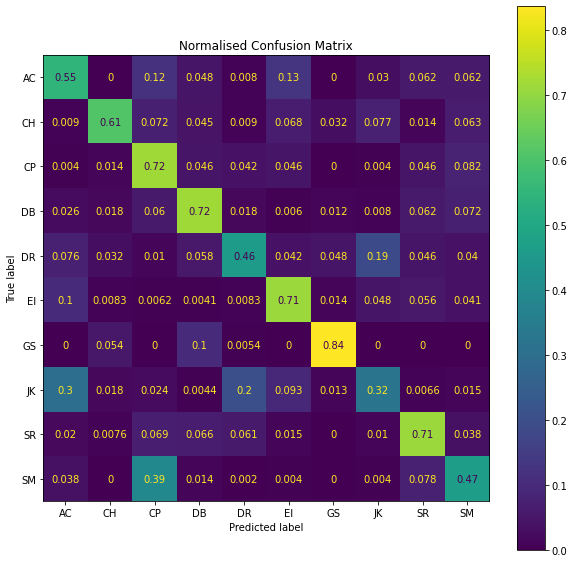

In [27]:
unified_X_test_feats = np.empty(shape=(0, 140))
unified_Y_test = unified_Y_test
for i in range(0, 5):
    unified_X_test_feats = np.append(unified_X_test_feats, X_test_feats[i], axis=0)

y_pred = feat_model.predict(unified_X_test_feats)
y_pred = np.argmax(y_pred, axis=1) 
y_target = np.argmax(unified_Y_test, axis=1)

cm = confusion_matrix(y_target, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_shorten)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalised Confusion Matrix")
disp.plot(ax=ax)

print(classification_report(y_target, y_pred, target_names=classes, digits=4))

In [28]:
cvscores = []
for i in range(0,len(X_test)):
  scores = feat_model.evaluate(X_test_feats[i], Y_test[i], verbose=0)
  cvscores.append(scores[1]*100)
  print("{0} {1}: {2:.2f}".format(test_folds[i], cnn_model.metrics_names[1], scores[1]*100))
print("mean accuracy: {0:.2f}%   standard deviation: {1:.2}%".format(np.mean(cvscores), np.std(cvscores)))

fold5 accuracy: 55.98
fold7 accuracy: 62.17
fold8 accuracy: 54.09
fold9 accuracy: 59.19
fold10 accuracy: 65.59
mean accuracy: 59.41%   standard deviation: 4.1%


plotting a comparison graph between the two models

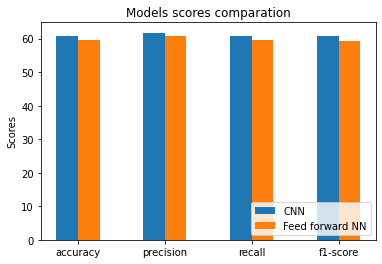

In [29]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['accuracy', 'precision', 'recall', 'f1-score' ]
cnn_means = [60.79, 61.77, 60.74, 60.83]
nn_means = [59.55, 60.66, 59.46, 59.39]

x = np.arange(len(labels))  # the label locations

width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cnn_means, width, label='CNN')
rects2 = ax.bar(x + width/2, nn_means, width, label='Feed forward NN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Models scores comparation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

#fig.tight_layout()
plt.show()